## SteamGames
#### Sheida Majidi

# causal inference project

In [1]:
import sys
import pandas as pd
import numpy as np
from packaging import version
import sklearn
import ast
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

### Load Data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_games_data():
    tarball_path = Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.kaggle.com/datasets/mexwell/steamgames/data"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as games_tarball:
            games_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv"))

games = load_games_data()

### Preprocess Data

In [3]:
games.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


#### Data Cleaning 

##### Handling missing values

In [4]:
# Dropping specified columns with more than 85% missing values
columns_to_drop = ['Reviews', 'Score rank', 'Metacritic url', 'Notes']
for column in columns_to_drop:
    if games[column].isnull().mean() > 0.85:
        games.drop(column, axis=1, inplace=True)

# Saving the modified dataset 
#games.to_csv("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/SteamGames/games_cleaned.csv", index=False) 

In [5]:
# Impute missing values

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
numeric_cols = games.select_dtypes(include=[np.number])

iterative_imputer = IterativeImputer()
imputed_data = iterative_imputer.fit_transform(numeric_cols)

# Creating a DataFrame with the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols.columns)

# Merging imputed numeric data back with non-numeric data
games[numeric_cols.columns] = imputed_df


In [6]:
# Select only numeric columns
numeric_columns = games.select_dtypes(include=[np.number]).columns

# Print the list of numeric columns
print("Numeric columns in the dataset:")
print(numeric_columns.tolist())

Numeric columns in the dataset:
['AppID', 'Peak CCU', 'Required age', 'Price', 'DLC count', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks']


##### Handling categorical columns

In [7]:
# Process the 'Suppported languages' column

from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=['Supported languages'], random_state=42)

In [8]:
# Process the 'Full audio languages' column

# Function to convert list of languages into a single string
def concat_languages(lang_list):
    return ', '.join(lang_list) if isinstance(lang_list, list) else lang_list

# Apply the function to the 'Full audio languages' column
games['Full audio languages'] = games['Full audio languages'].apply(concat_languages)

# Prepare your features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

X = games[numeric_cols + ['Full audio languages']]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=['Full audio languages'], random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5731.8134970	total: 71.2ms	remaining: 1m 11s
1:	learn: 5624.9583838	total: 89.3ms	remaining: 44.6s
2:	learn: 5539.9867463	total: 96.2ms	remaining: 32s
3:	learn: 5418.0358263	total: 106ms	remaining: 26.4s
4:	learn: 5300.9617579	total: 112ms	remaining: 22.3s
5:	learn: 5247.5105625	total: 118ms	remaining: 19.6s
6:	learn: 5196.4251373	total: 124ms	remaining: 17.6s
7:	learn: 5146.7809174	total: 129ms	remaining: 16s
8:	learn: 5098.2620089	total: 137ms	remaining: 15.1s
9:	learn: 5051.6597366	total: 144ms	remaining: 14.3s
10:	learn: 4946.5697611	total: 149ms	remaining: 13.4s
11:	learn: 4903.3706849	total: 155ms	remaining: 12.8s
12:	learn: 4861.8649109	total: 161ms	remaining: 12.2s
13:	learn: 4821.6106216	total: 167ms	remaining: 11.7s
14:	learn: 4782.6437441	total: 174ms	remaining: 11.4s
15:	learn: 4745.1269425	total: 180ms	remaining: 11.1s
16:	learn: 4708.9366963	total: 186ms	remaining: 10.8s
17:	learn: 4674.0279912	total: 193ms	remaining: 10.5s
18:	lear

In [9]:
# Process the 'Genres', 'Categories', and 'Tags' columns

# Function to transform comma-separated strings into single strings
def transform_column(col):
    return col.apply(lambda x: x if isinstance(x, str) else '')

# Apply the function to the 'Genres', 'Categories', and 'Tags' columns
games['Genres'] = transform_column(games['Genres'])
games['Categories'] = transform_column(games['Categories'])
games['Tags'] = transform_column(games['Tags'])

# Prepare features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

categorical_cols = ['Genres', 'Categories', 'Tags', 'Full audio languages']

X = games[numeric_cols + categorical_cols]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=categorical_cols, random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5686.5455053	total: 10.7ms	remaining: 10.7s
1:	learn: 5577.5465623	total: 23.1ms	remaining: 11.6s
2:	learn: 5517.3043343	total: 33.7ms	remaining: 11.2s
3:	learn: 5459.3824489	total: 42.8ms	remaining: 10.6s
4:	learn: 5377.5345604	total: 49.9ms	remaining: 9.94s
5:	learn: 5317.9421838	total: 62ms	remaining: 10.3s
6:	learn: 5266.7216925	total: 72.2ms	remaining: 10.2s
7:	learn: 5217.3090399	total: 79.3ms	remaining: 9.83s
8:	learn: 5169.6983236	total: 88.8ms	remaining: 9.78s
9:	learn: 5123.5804208	total: 98.1ms	remaining: 9.71s
10:	learn: 5078.9948820	total: 109ms	remaining: 9.76s
11:	learn: 5030.7479132	total: 118ms	remaining: 9.73s
12:	learn: 4988.6632463	total: 127ms	remaining: 9.64s
13:	learn: 4948.3148090	total: 135ms	remaining: 9.54s
14:	learn: 4911.0359051	total: 142ms	remaining: 9.31s
15:	learn: 4873.8370548	total: 151ms	remaining: 9.26s
16:	learn: 4838.3357817	total: 156ms	remaining: 9.04s
17:	learn: 4804.1625988	total: 165ms	remaining: 8.99s


##### Handing text "about the game"

In [10]:
games['About the game']


0        Galactic Bowling is an exaggerated and stylize...
1        THE LAW!! Looks to be a showdown atop a train....
2        Jolt Project: The army now has a new robotics ...
3        HENOSIS™ is a mysterious 2D Platform Puzzler w...
4        ABOUT THE GAME Play as a hacker who has arrang...
                               ...                        
71711    Innovative Gameplay SUR5 brings a brand new, f...
71712    Core Features Real players only! All Guards an...
71713    Architecture Zeitgeist is a game created with ...
71714    Development progress: prologue map (finished),...
71715    'Hentai Ariel' is a unique puzzle in which the...
Name: About the game, Length: 71716, dtype: object

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

#import nltk
import re
#from nltk.tokenize import RegexpTokenizer
def clean_text(text):
    if isinstance(text, str):
        # Remove special characters and convert to lowercase
        text_cleaned = re.sub(r'[^a-zA-Z0-9 ]', '', text).lower()
    else:
        # If the value is missing, replace it with an empty string
        text_cleaned = text
    return text_cleaned

#regexp = RegexpTokenizer('\w+')
games['cleaned_text'] = games['About the game'].apply(lambda x:clean_text(x))
games['cleaned_text'] = games['cleaned_text'].fillna('no text')

In [12]:
vect = CountVectorizer(stop_words='english', max_features=1000)
vect.fit_transform(games['cleaned_text']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##### removing outliers using IsolationForest

In [13]:
from sklearn.ensemble import IsolationForest

# Selecting numerical columns for outlier detection
numeric_columns = games.select_dtypes(include=[np.number]).columns

# Creating the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=123)

# Fitting the model on  numerical data
outliers = iso_forest.fit_predict(games[numeric_columns])

games['outlier'] = outliers

# Filtering the DataFrame to remove outliers (outliers are marked with -1)
games_filtered = games[games['outlier'] == 1]

# Dropping the 'outlier' column as it's no longer needed
games_filtered = games_filtered.drop(columns=['outlier'])

### Causal Inference

In [14]:
games_filtered

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies,cleaned_text
0,20200.0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0.0,0.0,19.99,0.0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0.0,0.0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,galactic bowling is an exaggerated and stylize...
1,655370.0,Train Bandit,"Oct 12, 2017",0 - 20000,0.0,0.0,0.99,0.0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0.0,0.0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,the law looks to be a showdown atop a train th...
2,1732930.0,Jolt Project,"Nov 17, 2021",0 - 20000,0.0,0.0,4.99,0.0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0.0,0.0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,jolt project the army now has a new robotics p...
3,1355720.0,Henosis™,"Jul 23, 2020",0 - 20000,0.0,0.0,5.99,0.0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0.0,0.0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,henosis is a mysterious 2d platform puzzler wh...
4,1139950.0,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0.0,0.0,0.00,0.0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0.0,0.0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,about the game play as a hacker who has arrang...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2159120.0,SUR5,"Apr 1, 2023",0 - 0,0.0,0.0,0.00,0.0,"Innovative Gameplay SUR5 brings a brand new, f...","['English', 'Polish', 'Spanish - Latin America']",...,0.0,0.0,Katharsis,Katharsis,"Single-player,Multi-player,PvP,Online PvP,Stea...","Free to Play,Indie,Massively Multiplayer,Strat...",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,innovative gameplay sur5 brings a brand new fu...
71712,2125160.0,Prison Life 2,"Mar 30, 2023",0 - 20000,6.0,0.0,10.79,0.0,Core Features Real players only! All Guards an...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0.0,0.0,AO Games,AO Games,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Casual,Indie,RPG,Simulation,Strategy","First-Person,Detective,Social Deduction,Multip...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,core features real players only all guards and...
71713,2318860.0,Architecture Zeitgeist,"Mar 27, 2023",0 - 20000,0.0,0.0,5.99,0.0,Architecture Zeitgeist is a game created with ...,"['English', 'Japanese', 'Portuguese - Brazil',...",...,0.0,0.0,Matheus Rudo,Rudo Studios,Single-player,"Casual,Simulation,Early Access","Casual,Simulation,Puzzle,Exploration,Immersive...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,architecture zeitgeist is a game created with ...
71714,2

##### Categorizing "Price" column (treatment)

In [16]:
# Define the price categories
def categorize_price(price):
    if price == 0:
        return 'free'
    elif price <= games_filtered['Price'].quantile(0.25):
        return 'low-cost'
    elif price > games_filtered['Price'].quantile(0.25) and price <= games_filtered['Price'].quantile(0.75):
        return 'mid-range'
    else:
        return 'high-cost'

# Apply the function to the 'Price' column
games_filtered['Price Category'] = games_filtered['Price'].apply(categorize_price)


Price Category
mid-range    36358
high-cost    11906
free         11894
low-cost      7698
Name: count, dtype: int64


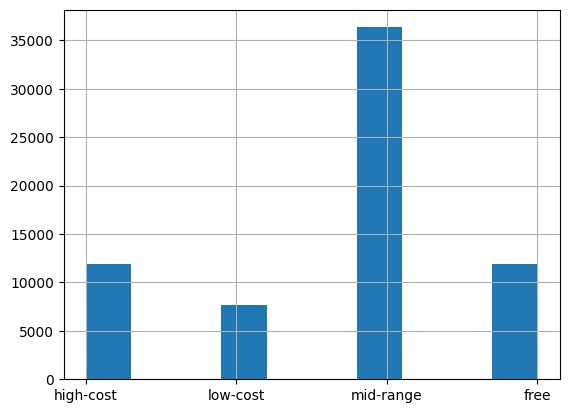

In [19]:
games_filtered['Price Category'].hist()
print(games_filtered['Price Category'].value_counts())